#  Modeling Financial Returns: The Limits of Prediction

Neural networks are often celebrated for their ability to model complex relationships — but they have a fundamental limitation: **they cannot learn information that is not present in the input**.

In financial modeling, we frequently work with just price-based data — such as daily returns. If we attempt to predict future returns using only past returns, there's often very little true **signal** and a lot of **noise**.

This lesson walks through:

- Using **lagged daily SPX returns** to predict next-day returns
- Comparing a **linear regression** and a **neural network**
- Highlighting how both models fail to outperform each other meaningfully — because the information needed for accurate prediction simply isn’t there

Ultimately, we'll see that:
> **Neural networks are great for what they’re great at — but only when the data provides enough structure to learn from.**


##  Step 1: Visualize the Distribution and Structure of Returns

We'll start by examining the distribution of daily returns and plotting the relationship between lagged returns and next-day returns.

This gives us a feel for whether there's any signal to learn — or if it's just noise.


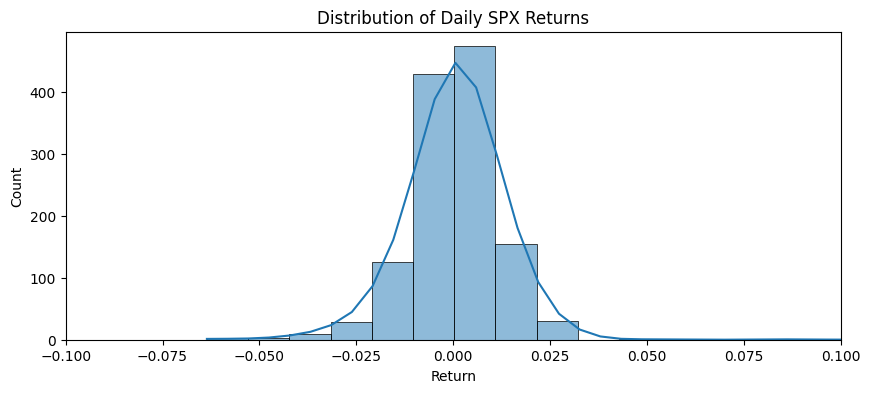

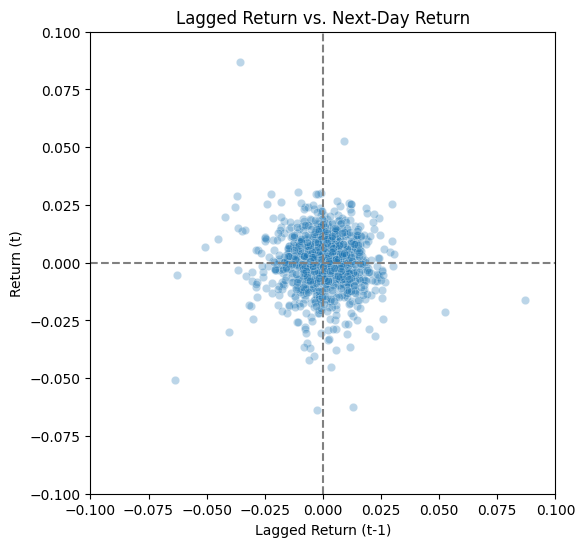

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spx = pd.read_csv('spx_returns.csv')

# Create lagged features
spx['lag_return'] = spx['Return'].shift(1)
spx = spx.dropna()

# Plot distribution
plt.figure(figsize=(10, 4))
sns.histplot(spx['Return'], bins=100, kde=True)
plt.title("Distribution of Daily SPX Returns")
plt.xlim((-.1, .1))
plt.show()

# Plot scatter of lagged vs. next-day returns
plt.figure(figsize=(6, 6))
sns.scatterplot(x='lag_return', y='Return', data=spx, alpha=0.3)
plt.title("Lagged Return vs. Next-Day Return")
plt.xlabel("Lagged Return (t-1)")
plt.ylabel("Return (t)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim((-.1, .1))
plt.ylim((-.1, .1))
plt.show()

##  What Can We Actually Learn From This?

The scatter plot shows a **cloud of noise** — very little linear or non-linear structure between today’s return and tomorrow’s return.

This is expected:
- **Markets are (mostly) efficient**.
- Price returns often behave like **random noise**.
- **Autocorrelation** in returns is weak or nonexistent in daily data.

Still, we’ll fit two models:
- A **linear regression**, to serve as a baseline
- A **neural network**, to see if additional flexibility can help

Our hypothesis is:
> **Both models will perform similarly poorly**, because **we're asking them to extract signal that doesn't exist**.

##  Step 2: Prepare the Data (Chronological Train-Test Split)

In time series modeling, we must split the data **chronologically** — using earlier data for training and later data for testing.

This simulates the real-world scenario: we train a model


In [15]:
from sklearn.preprocessing import StandardScaler
import torch

# Inputs and targets
X = spx[['lag_return']].values
y = spx[['Return']].values

# Chronological split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Scale inputs and targets using training data only
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

##  Step 3: Linear Regression

This baseline model assumes a linear relationship between lagged and next-day return. While overly simple, it's a good sanity check — and likely to perform as well as more complex models when there's no meaningful signal in the data.

In [16]:
import torch.nn as nn
import torch.optim as optim

linear_model = nn.Linear(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(linear_model.parameters(), lr=0.01)

for epoch in range(300):
    optimizer.zero_grad()
    y_pred = linear_model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    mse_train_linear = criterion(linear_model(X_train_tensor), y_train_tensor).item()
    mse_test_linear = criterion(linear_model(X_test_tensor), y_test_tensor).item()

mse_train_linear, mse_test_linear

(0.9999161958694458, 33.503055572509766)

##  Step 4: Neural Network

Now we introduce a neural network with hidden layers. In theory, it can learn more subtle or non-linear relationships.

However, without sufficient information, even a neural network will **learn noise** and not generalize well — especially in financial data where true signals are rare and fragile.

In [17]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

nn_model = NeuralNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.01)

for epoch in range(300):
    optimizer.zero_grad()
    y_pred = nn_model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    mse_train_nn = criterion(nn_model(X_train_tensor), y_train_tensor).item()
    mse_test_nn = criterion(nn_model(X_test_tensor), y_test_tensor).item()

mse_train_nn, mse_test_nn

(0.9518880844116211, 33.75197219848633)

##  Step 5: Compare Results

Let’s look at the mean squared error (MSE) on the training and test sets for both models.

In theory:
- If there's **true signal**, the neural net might edge out the linear model.
- If not, it will just overfit and may perform worse out-of-sample.

In [18]:
print(f"Linear Regression - Train MSE: {mse_train_linear:.4f}, Test MSE: {mse_test_linear:.4f}")
print(f"Neural Network     - Train MSE: {mse_train_nn:.4f}, Test MSE: {mse_test_nn:.4f}")

Linear Regression - Train MSE: 0.9999, Test MSE: 33.5031
Neural Network     - Train MSE: 0.9519, Test MSE: 33.7520


##  Final Takeaways

- We tried to predict **next-day SPX returns** using **only past returns**.
- There was no meaningful pattern to learn — the data was mostly **random noise**.
- As expected:
  - The **linear model** performed about as well as the **neural network**.
  - The neural network may even have **overfit** to noise in training data.

This illustrates a core truth in modeling:

> **No model — no matter how complex — can generate predictive power from nothing.**

To build predictive financial models, we often need:
- **Additional features** (volatility, macro data, order flow, etc.)
- **Domain knowledge** to design more informative inputs

Neural networks shine **only when the data contains enough structure** to make learning possible.

Otherwise, simpler models like linear regression are not just sufficient — they're more robust and transparent.